In [2]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as la
import itertools
import xgboost as xgb
from pandas import Series
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cross_validation import *
from sklearn.grid_search import GridSearchCV

C:\Users\Ali\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Ali\Anaconda2\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
trainSet = pd.read_csv('data/SuperCleanAlmost.csv')

trainSet = trainSet.set_index('id')

##trainSet = trainSet.drop(['poster_path'], axis=1)
##trainSet = trainSet.drop(['backdrop_path'], axis=1)
##trainSet = trainSet.drop(['adult'], axis = 1)

trainSet = trainSet.drop(['genres'], axis=1)
trainSet = trainSet.drop(['original_language'], axis=1)
trainSet = trainSet.drop(['original_title'], axis=1)
trainSet = trainSet.drop(['production_companies'], axis=1)
trainSet = trainSet.drop(['production_countries'], axis = 1)

trainSet = trainSet.drop(['release_date'], axis=1)
trainSet = trainSet.drop(['spoken_languages'], axis=1)
trainSet = trainSet.drop(['status'], axis=1)
trainSet = trainSet.drop(['tagline'], axis=1)
trainSet = trainSet.drop(['title'], axis = 1)

X = trainSet.fillna(trainSet.mean())

In [76]:
trainSet.describe()
trainSet.head()

,belongs_to_collection,popularity,runtime,vote_count,vote_average,movie_id,Actor1_pop,Actor2_pop,Actor3_pop,12,...,10769,10770,Number of Production Companies,Release Month,'US','CA','GB',OTHER,'en','otherLang'
id,,,,,,,,,,,,,,,,,,,,,
339964,0,278.579364,137.0,1347,6.7,339964,9.460488,5.426100,4.771382,1,...,0,0,11,7.0,1,1,1,1,0,0
35691,0,18.178478,110.0,39,6.6,35691,2.222239,0.860164,0.715197,0,...,0,0,1,4.0,1,0,0,0,0,0
112160,0,10.089318,81.0,96,4.2,112160,0.816190,0.615657,0.614648,0,...,0,0,2,5.0,0,0,0,1,0,0
64690,0,12.873933,100.0,4118,7.5,64690,6.754838,6.189796,5.170999,0,...,0,0,6,8.0,1,0,0,0,0,0
1018,0,10.699658,147.0,1655,7.7,1018,7.209498,3.459744,2.761127,0,...,0,0,5,5.0,1,0,0,1,0,0


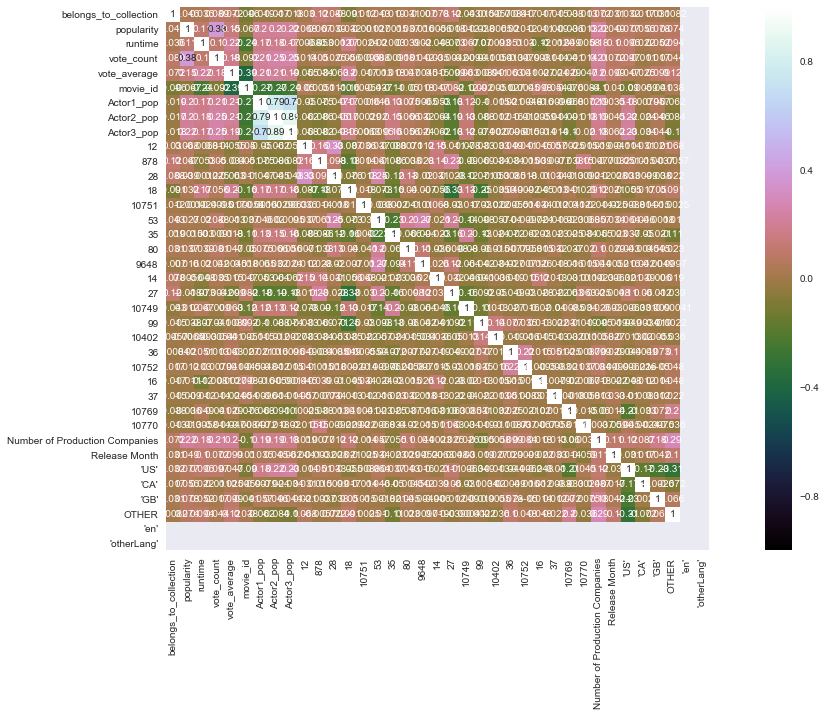

In [4]:
corr_mat=X.corr(method='pearson')
plt.figure(figsize=(20,10))
sns.heatmap(corr_mat,vmax=1,square=True,annot=True,cmap='cubehelix')

In [5]:
X_train = np.asarray(X.values)
X_std=StandardScaler().fit_transform(X_train)

In [84]:
X_train.shape

(3234L, 20L)

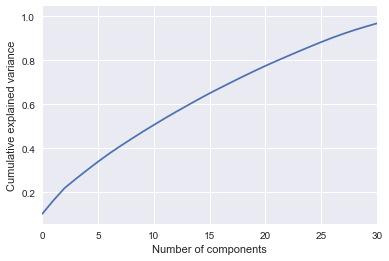

In [6]:
from sklearn.decomposition import PCA
pca = PCA().fit(X_std)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,30,2)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

In [7]:
sklearn_pca=PCA(n_components=20)
X_train=sklearn_pca.fit_transform(X_std)

In [8]:
y = trainSet['vote_average']
X = X_train

train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=.33,random_state=12)

In [86]:
from sklearn.linear_model import RidgeCV, ElasticNetCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [87]:
alphas = [0.01, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75, 100, 200, 1000, 5000]
r_cv = RidgeCV(alphas=alphas)
r_cv.fit(train_X,train_y)
print r_cv.alpha_
print r_cv.score(test_X,test_y)
print mean_squared_error(test_y,r_cv.predict(test_X))

100.0
0.686396877202
1.94601474377


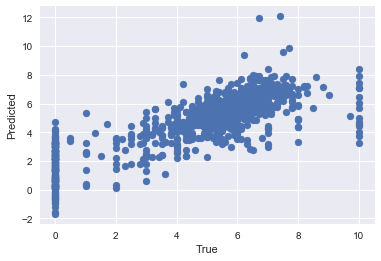

In [96]:
plt.scatter(test_y,r_cv.predict(test_X))
plt.xlabel('True') 
plt.ylabel('Predicted') 

In [89]:
l1_ratio = [.1, .5, .7, .9, .95, .99, 1]
en_cv = ElasticNetCV(alphas=alphas,l1_ratio=l1_ratio)
en_cv.fit(train_X,train_y)
print en_cv.alpha_
print en_cv.l1_ratio_
print en_cv.score(test_X,test_y)
print mean_squared_error(test_y,en_cv.predict(test_X))

0.05
0.1
0.685720458189
1.95021215532


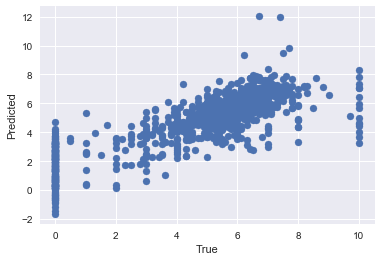

In [94]:
plt.scatter(test_y,en_cv.predict(test_X))
plt.xlabel('True') 
plt.ylabel('Predicted') 

In [9]:
from sklearn.neighbors import KNeighborsRegressor

In [21]:
knn = GridSearchCV(KNeighborsRegressor(),dict(n_neighbors=np.arange(1,5)),cv=5,scoring='neg_mean_squared_error')

In [22]:
knn.fit(train_X,train_y)
print knn.score(test_X,test_y)
print mean_squared_error(test_y,knn.predict(test_X))

-2.24859784644
2.24859784644


In [23]:
from sklearn.tree import DecisionTreeRegressor

In [24]:
dtree = GridSearchCV(DecisionTreeRegressor(), dict(min_samples_split=[4,16,64,256,1024],min_samples_leaf=[4,16,64,256,1024],splitter=['best','random']),cv=5,scoring='neg_mean_squared_error')

In [25]:
dtree.fit(train_X,train_y)
print dtree.score(test_X,test_y)
print mean_squared_error(test_y,dtree.predict(test_X))

-3.06476527457
3.06476527457


In [11]:
from xgboost import XGBRegressor

In [11]:
# xgb1 = XGBRegressor(learning_rate=0.1,n_estimators=1000,max_depth=5,min_child_weight=1,gamma=0,subsample=0.8,colsample_bytree=0.8,objective='reg:linear',scale_pos_weight=1,seed=1)
# def fit(xgb1,trainX,trainY):
#     param = xgb1.get_params()
#     xgbtrain = xgb.DMatrix(trainX,label=trainY.values)
#     cv = xgb.cv(param,xgbtrain,num_boost_round=param['n_estimators'],nfold=5,metrics='mse', early_stopping_rounds=50)
#     xgb1.set_params(n_estimators=cv.shape[0])
#     xgb1.fit(trainX,trainY,eval_metric='mse')

In [27]:
xgb2 = GridSearchCV(estimator = XGBRegressor( learning_rate=0.1, n_estimators=140, max_depth=5,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'reg:linear', nthread=4,scale_pos_weight=1,seed=27), 
 param_grid = dict(max_depth=range(4,8),min_child_weight=range(4,9)), scoring='neg_mean_squared_error',iid=False, cv=5)
xgb2.fit(train_X,train_y)
print xgb2.best_params_, xgb2.best_score_
print xgb2.score(test_X,test_y)
print mean_squared_error(test_y,xgb2.predict(test_X))

{'max_depth': 5, 'min_child_weight': 6} -1.31715193278
-1.22043989369
1.22043989369


In [29]:
xgb3 = GridSearchCV(estimator = XGBRegressor( learning_rate=0.1, n_estimators=140, max_depth=5,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'reg:linear', scale_pos_weight=1,seed=27), 
 param_grid = dict(gamma=[i/10.0 for i in range(5,8)]), scoring='neg_mean_squared_error',iid=False, cv=5)
xgb3.fit(train_X,train_y)
print xgb3.best_params_, xgb3.best_score_
print mean_squared_error(test_y,xgb3.predict(test_X))

{'gamma': 0.6} -1.3359171762
1.23080082973


In [34]:
xgb4 = GridSearchCV(estimator = XGBRegressor( learning_rate=0.1, n_estimators=140, max_depth=5,
 min_child_weight=6, gamma=0.6, subsample=0.8, colsample_bytree=0.8,
 objective= 'reg:linear', scale_pos_weight=1,seed=27), 
 param_grid = dict(subsample=[i/10.0 for i in range(4,8)],colsample_bytree=[i/10.0 for i in range(6,10)]), 
 scoring='neg_mean_squared_error',iid=False, cv=5)
xgb4.fit(train_X,train_y)
print xgb4.best_params_, xgb4.best_score_
print mean_squared_error(test_y,xgb4.predict(test_X))

{'subsample': 0.5, 'colsample_bytree': 0.9} -1.27915917136
1.25083533273


In [59]:
xgb5 = GridSearchCV(estimator = XGBRegressor( learning_rate=0.1, n_estimators=140, max_depth=5,
 min_child_weight=6, gamma=0.6, subsample=0.5, colsample_bytree=0.8,
 objective= 'reg:linear', scale_pos_weight=1,seed=27), 
 param_grid = dict(subsample=[i/100.0 for i in range(45,60,5)],colsample_bytree=[i/100.0 for i in range(85,100,5)]), 
 scoring='neg_mean_squared_error',iid=False, cv=5)
xgb5.fit(train_X,train_y)
print xgb5.best_params_, xgb5.best_score_
print mean_squared_error(test_y,xgb5.predict(test_X))

{'subsample': 0.5, 'colsample_bytree': 0.95} -1.19057249874
1.10998423155


In [60]:
xgb6 = GridSearchCV(estimator = XGBRegressor( learning_rate=0.1, n_estimators=140, max_depth=5,
 min_child_weight=6, gamma=0.6, subsample=0.5, colsample_bytree=0.95,
 objective= 'reg:linear', scale_pos_weight=1,seed=27), 
 param_grid = dict(reg_alpha=[1e-5, 1e-2, 0.1, 1, 100],reg_lambda=[1e-5, 1e-2, 0.1, 1, 100]), 
 scoring='neg_mean_squared_error',iid=False, cv=5)
xgb6.fit(train_X,train_y)
print xgb6.best_params_, xgb6.best_score_
print mean_squared_error(test_y,xgb6.predict(test_X))

{'reg_alpha': 0.01, 'reg_lambda': 1} -1.18934855487
1.11641173364


In [61]:
xgb7 = GridSearchCV(estimator = XGBRegressor( learning_rate=0.1, n_estimators=140, max_depth=5,
 min_child_weight=6, gamma=0.6, subsample=0.5, colsample_bytree=0.95,
 objective= 'reg:linear', scale_pos_weight=1,seed=27), 
 param_grid = dict(reg_alpha=[0, 1e-3,1e-2,1e-1],reg_lambda=[0, 1e-1,1e0,1e1]), 
 scoring='neg_mean_squared_error',iid=False, cv=5)
xgb7.fit(train_X,train_y)
print xgb7.best_params_, xgb7.best_score_
print mean_squared_error(test_y,xgb7.predict(test_X))

{'reg_alpha': 0.1, 'reg_lambda': 10.0} -1.15464713112
1.12742255698


In [62]:
xgb8 = GridSearchCV(estimator = XGBRegressor( learning_rate=0.1, n_estimators=140, max_depth=5,
 min_child_weight=6, gamma=0.6, subsample=0.5, colsample_bytree=0.95,
 reg_alpha=0.1,reg_lambda=10,
 objective= 'reg:linear', scale_pos_weight=1,seed=27), 
 param_grid = dict(learning_rate=[0.001,0.005,0.01,0.05],n_estimators=[500,1000,5000]), 
 scoring='neg_mean_squared_error',iid=False, cv=5)
xgb8.fit(train_X,train_y)
print xgb8.best_params_, xgb8.best_score_
print mean_squared_error(test_y,xgb8.predict(test_X))

{'n_estimators': 5000, 'learning_rate': 0.01} -0.958042481826
0.891206006695


In [63]:
xgb8 = XGBRegressor( learning_rate=0.01, n_estimators=8000, max_depth=5,
 min_child_weight=6, gamma=0.6, subsample=0.5, colsample_bytree=0.95,
 reg_alpha=0.1,reg_lambda=10,
 objective= 'reg:linear', scale_pos_weight=1)
# fit(xgb8,train_X,train_y)
xgb8.fit(train_X,train_y)
print xgb8.score(train_X,train_y)
print mean_squared_error(test_y,xgb8.predict(test_X))

0.989436961236
0.877806392451


In [64]:
preds = np.array(xgb8.predict(test_X))
mean_squared_error(test_y,preds)

0.87780639245140535

In [65]:
pred = pd.DataFrame(preds,index = test_y.index,columns=['prediction'])

In [66]:
out = pd.concat((pred,test_y),axis=1)
out.to_csv('data/predictions2.csv')

In [67]:
preds = []
for i in range(50):
    xgb8 = XGBRegressor( learning_rate=0.01, n_estimators=5000, max_depth=5,
     min_child_weight=6, gamma=0.6, subsample=0.5, colsample_bytree=0.95,
     reg_alpha=0.1,reg_lambda=10, seed=i,
     objective= 'reg:linear', scale_pos_weight=1)
    # fit(xgb8,train_X,train_y)
    xgb8.fit(train_X,train_y)
    print 'R{}:'.format(i),xgb8.score(train_X,train_y)
    p = xgb8.predict(test_X)
    print 'R{}:'.format(i),mean_squared_error(test_y,p)
    preds.append(p)

R0: 0.98767879643
R0: 0.88564913975
R1: 0.987624818844
R1: 0.889351041965
R2: 0.987685641242
R2: 0.890974445945
R3: 0.987587166539
R3: 0.895480739004
R4: 0.987669788601
R4: 0.898424708971
R5: 0.987619601288
R5: 0.896825990092
R6: 0.987621374845
R6: 0.907892726684
R7: 0.987583931764
R7: 0.894409756179
R8: 0.987625968238
R8: 0.874545694513
R9: 0.987670884512
R9: 0.903625397555
R10: 0.987672106153
R10: 0.887877401801
R11: 0.987502189459
R11: 0.885320133704
R12: 0.987604424819
R12: 0.888850461425
R13: 0.98759729237
R13: 0.876556333579
R14: 0.987688341116
R14: 0.89748863574
R15: 0.987735006384
R15: 0.895623941302
R16: 0.987729363982
R16: 0.89321588347
R17: 0.987692779779
R17: 0.888305029167
R18: 0.987727501746
R18: 0.895236965178
R19: 0.987653926524
R19: 0.897408812961
R20: 0.987650234811
R20: 0.890877733283
R21: 0.987610817501
R21: 0.893819085659
R22: 0.987664158162
R22: 0.886653596487
R23: 0.987630466185
R23: 0.889129116968
R24: 0.987677081985
R24: 0.891038454693
R25: 0.987736950392
R25: 

In [68]:
preds = np.array(preds)
mean_squared_error(test_y,preds.mean(axis=0))

0.88232477379297081

In [69]:
pred = pd.DataFrame(preds.mean(axis=0),index = test_y.index,columns=['prediction'])

In [70]:
out = pd.concat((pred,test_y),axis=1)
out.to_csv('data/predictions3.csv')

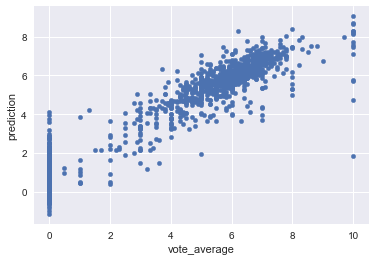

In [97]:
out.plot(x='vote_average',y='prediction',kind='scatter')